In [1]:
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
from bellek.dvc.experiment import load_experiments

experiments = load_experiments('minimal-prompts.json')
print(f"{len(experiments)} experiments")
experiments[0]

19 experiments


{'commit': 'workspace',
 'id': 'workspace',
 'name': None,
 'params': {'dataset': {'path': 'bdsaglam/musique',
   'name': 'answerable',
   'split': 'train'},
  'qa': {'model': 'llama-3-70b-tgi',
   'temperature': 0.1,
   'system_prompt': 'no-role.txt',
   'user_prompt_template': 'cq.txt',
   'few_shot_examples': 'empty.json'},
  'run': 1},
 'metrics': {'exact_match': 0.586568361921958,
  'f1': 0.6939285759126523,
  'fuzzy_match': 0.6545290400240746,
  '2hops': {'exact_match': 0.6145659432387313,
   'f1': 0.7205072396670257,
   'fuzzy_match': 0.6814134668892599},
  '3hops': {'exact_match': 0.49988602689765216,
   'f1': 0.6124656855355362,
   'fuzzy_match': 0.5767038978801003},
  '4hops': {'exact_match': 0.5676595744680851,
   'f1': 0.6728926865097078,
   'fuzzy_match': 0.6161702127659574}}}

In [3]:
df = pd.json_normalize(experiments).drop(columns=["commit", "id", "name"])

param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop_duplicates(subset=param_cols, inplace=True)

df = df.sort_values(
    [
        "params.qa.model",
        "params.qa.system_prompt",
        "params.qa.user_prompt_template",
        "params.qa.few_shot_examples",
        "params.run",
    ]
)
df = df[df['params.dataset.path']=='bdsaglam/musique-mini'].copy()
df.reset_index(drop=True, inplace=True)
df

,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.run,metrics.exact_match,...,metrics.fuzzy_match,metrics.2hops.exact_match,metrics.2hops.f1,metrics.2hops.fuzzy_match,metrics.3hops.exact_match,metrics.3hops.f1,metrics.3hops.fuzzy_match,metrics.4hops.exact_match,metrics.4hops.f1,metrics.4hops.fuzzy_match
0,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,minimal-output-format-answer-cue.txt,cq-sep.txt,empty.json,1,0.566667,...,0.626667,0.69,0.785429,0.76,0.54,0.661337,0.57,0.47,0.640170,0.55
1,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,minimal-output-format-answer-cue.txt,cq-sep.txt,empty.json,2,0.573333,...,0.633333,0.69,0.792095,0.76,0.55,0.669670,0.58,0.48,0.650170,0.56
2,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,minimal-output-format-answer-cue.txt,cq-sep.txt,empty.json,3,0.573333,...,0.633333,0.70,0.795429,0.77,0.53,0.655337,0.56,0.49,0.660170,0.57
3,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,minimal-output-format-answer-cue.txt,cq.txt,empty.json,1,0.576667,...,0.636667,0.70,0.788762,0.77,0.54,0.658670,0.56,0.49,0.666975,0.58
4,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,minimal-output-format-answer-cue.txt,cq.txt,empty.json,2,0.570000,...,0.630000,0.69,0.785429,0.76,0.54,0.658670,0.56,0.48,0.656975,0.57
5,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,minimal-output-format-answer-cue.txt,cq.txt,empty.json,3,0.573333,...,0.633333,0.70,0.788762,0.77,0.54,0.665365,0.56,0.48,0.656975,0.57
6,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,minimal-output-format.txt,cq-sep.txt,empty.json,1,0.546667,...,0.616667,0.63,0.748710,0.72,0.53,0.641813,0.58,0.48,0.626338,0.55
7,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,minimal-output-format.txt,cq-sep.txt,empty.json,2,0.543333,...,0.613333,0.63,0.748577,0.72,0.52,0.643983,0.57,0.48,0.627208,0.55
8,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,minimal-output-format.txt,cq-sep.txt,empty.json,3,0.546667,...,0.613333,0.62,0.740856,0.71,0.53,0.649847,0.58,0.49,0.624442,0.55
9,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,minimal-output-format.txt,cq.txt,empty.json,1,0.556667,...,0.623333,0.66,0.766675,0.75,0.53,0.642570,0.58,0.48,0.618517,0.54


In [8]:
import re

def parse_n_shot(x):
    if 'empty' in x:
        return 0
    # match the digit in the string
    x = re.search(r'\d+', x).group()
    return int(x)

assert parse_n_shot('empty.json') == 0
assert parse_n_shot('cot-2-shot.json') == 2

In [ ]:
df['params.qa.few_shot_examples'] = df['params.qa.few_shot_examples'].map(parse_n_shot)

In [10]:
run_counts = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples"])[
        metric_cols[:1]
    ]
    .count()
    .reset_index()
)
mask = run_counts[metric_cols[0]] < 3
run_counts.loc[mask]

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,metrics.exact_match


In [11]:
# Average metrics over repeated runs (params.run)
df_avg = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples"])[
        metric_cols
    ]
    .mean()
    .reset_index()
)
df_avg[["params.qa.system_prompt", 'params.qa.user_prompt_template', "params.qa.few_shot_examples", *metric_cols]].sort_values('metrics.2hops.f1', ascending=False)

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,metrics.exact_match,metrics.f1,metrics.fuzzy_match,metrics.2hops.exact_match,metrics.2hops.f1,metrics.2hops.fuzzy_match,metrics.3hops.exact_match,metrics.3hops.f1,metrics.3hops.fuzzy_match,metrics.4hops.exact_match,metrics.4hops.f1,metrics.4hops.fuzzy_match
0,minimal-output-format-answer-cue.txt,cq-sep.txt,0,0.571111,0.701090,0.631111,0.693333,0.790984,0.763333,0.540000,0.662115,0.570000,0.480000,0.650170,0.560000
1,minimal-output-format-answer-cue.txt,cq.txt,0,0.573333,0.702954,0.633333,0.696667,0.787651,0.766667,0.540000,0.660902,0.560000,0.483333,0.660309,0.573333
3,minimal-output-format.txt,cq.txt,0,0.551111,0.673827,0.616667,0.650000,0.763671,0.740000,0.526667,0.642396,0.576667,0.476667,0.615415,0.533333
2,minimal-output-format.txt,cq-sep.txt,0,0.545556,0.672419,0.614444,0.626667,0.746047,0.716667,0.526667,0.645214,0.576667,0.483333,0.625996,0.550000
4,minimal.txt,cq-sep.txt,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,minimal.txt,cq.txt,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
df_target = df_avg.copy()

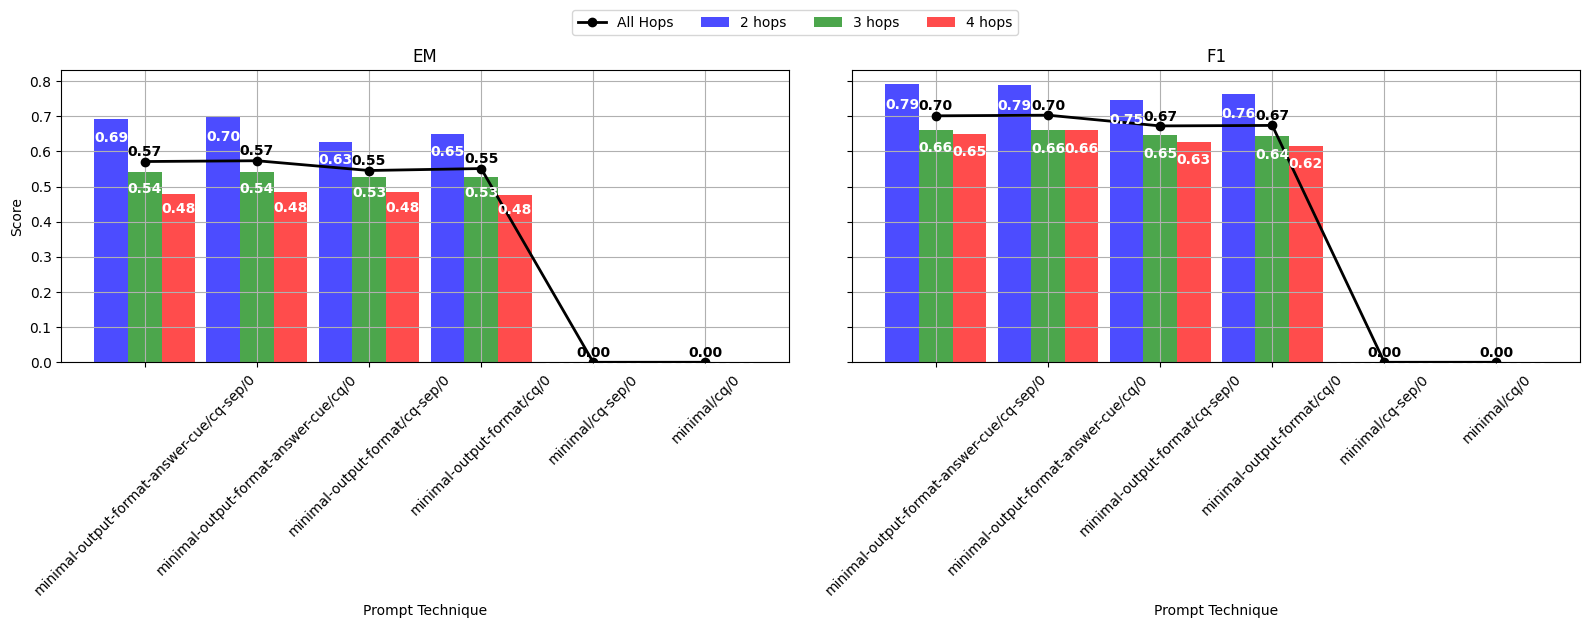

In [13]:
def plot_metric(ax, x, width, prompts, metrics, title, ylabel=None):
    bars_2hops = ax.bar(x - width, metrics["2hops"], width, label="2 hops", color="b", alpha=0.7)
    bars_3hops = ax.bar(x, metrics["3hops"], width, label="3 hops", color="g", alpha=0.7)
    bars_4hops = ax.bar(x + width, metrics["4hops"], width, label="4 hops", color="r", alpha=0.7)

    # Plotting all hops as a line plot
    ax.plot(x, metrics["all"], label="All Hops", color="k", linestyle="-", marker="o", linewidth=2)

    # Adding values inside the bars, just below the top
    for bars in [bars_2hops, bars_3hops, bars_4hops]:
        for bar in bars:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - (bar.get_height() * 0.05),
                f"{bar.get_height():.2f}",
                ha="center",
                va="top",
                fontsize=10,
                color="white",
                fontweight="bold",
            )

    # Adding values on top of the line plot
    for i, value in enumerate(metrics["all"]):
        ax.text(
            x[i],
            value + 0.007,
            f"{value:.2f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # Adjust titles and labels
    ax.set_title(title)
    ax.set_xlabel("Prompt Technique")
    ax.set_xticks(x)
    ax.set_xticklabels([prompt.replace(".txt", "") for prompt in prompts], rotation=45)
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.grid(True)


# Creating subplots for Exact Match and F1, separating them for clarity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

width = 0.3  # Bar width adjustment

# Changing the order of prompts to standard, cot-zs, cot-fs, cte
prompts = [f"{sp}/{up}/{fs}" for sp, up, fs in zip(df_target['params.qa.system_prompt'].values, df_target["params.qa.user_prompt_template"].values, df_target['params.qa.few_shot_examples'].values)]
x = np.arange(len(prompts))

# Plotting Exact Match
metrics_em = {
    "2hops": df_target["metrics.2hops.exact_match"].values,
    "3hops": df_target["metrics.3hops.exact_match"].values,
    "4hops": df_target["metrics.4hops.exact_match"].values,
    "all": df_target["metrics.exact_match"].values,
}
plot_metric(ax1, x, width, prompts, metrics_em, title="EM", ylabel="Score")

# Plotting F1
metrics_f1 = {
    "2hops": df_target["metrics.2hops.f1"].values,
    "3hops": df_target["metrics.3hops.f1"].values,
    "4hops": df_target["metrics.4hops.f1"].values,
    "all": df_target["metrics.f1"].values,
}
plot_metric(ax2, x, width, prompts, metrics_f1, title="F1")

# Creating a shared legend outside the plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)

plt.tight_layout()
plt.show()